**Amazon Stock Price Forecasting with TimeGPT**

In [1]:
%%capture
%pip install nixtla>=0.5.1
%pip install yfinance

In [2]:
import pandas as pd
import yfinance as yf
from nixtla import NixtlaClient
import os

In [3]:
# Install 'zstandard' module
!pip install zstandard

Defaulting to user installation because normal site-packages is not writeable


In [4]:
timegpt_api_key = os.environ["TIMEGPT_API_KEY"]

# Setup NixtlaClient
nixtla_client = NixtlaClient(api_key = timegpt_api_key)

In [5]:
# Downloading Amazon stock price data
ticker = 'AMZN'
amazon_stock_data = yf.download(ticker)
amazon_stock_data = amazon_stock_data.reset_index()

# Displaying the dataset
amazon_stock_data.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


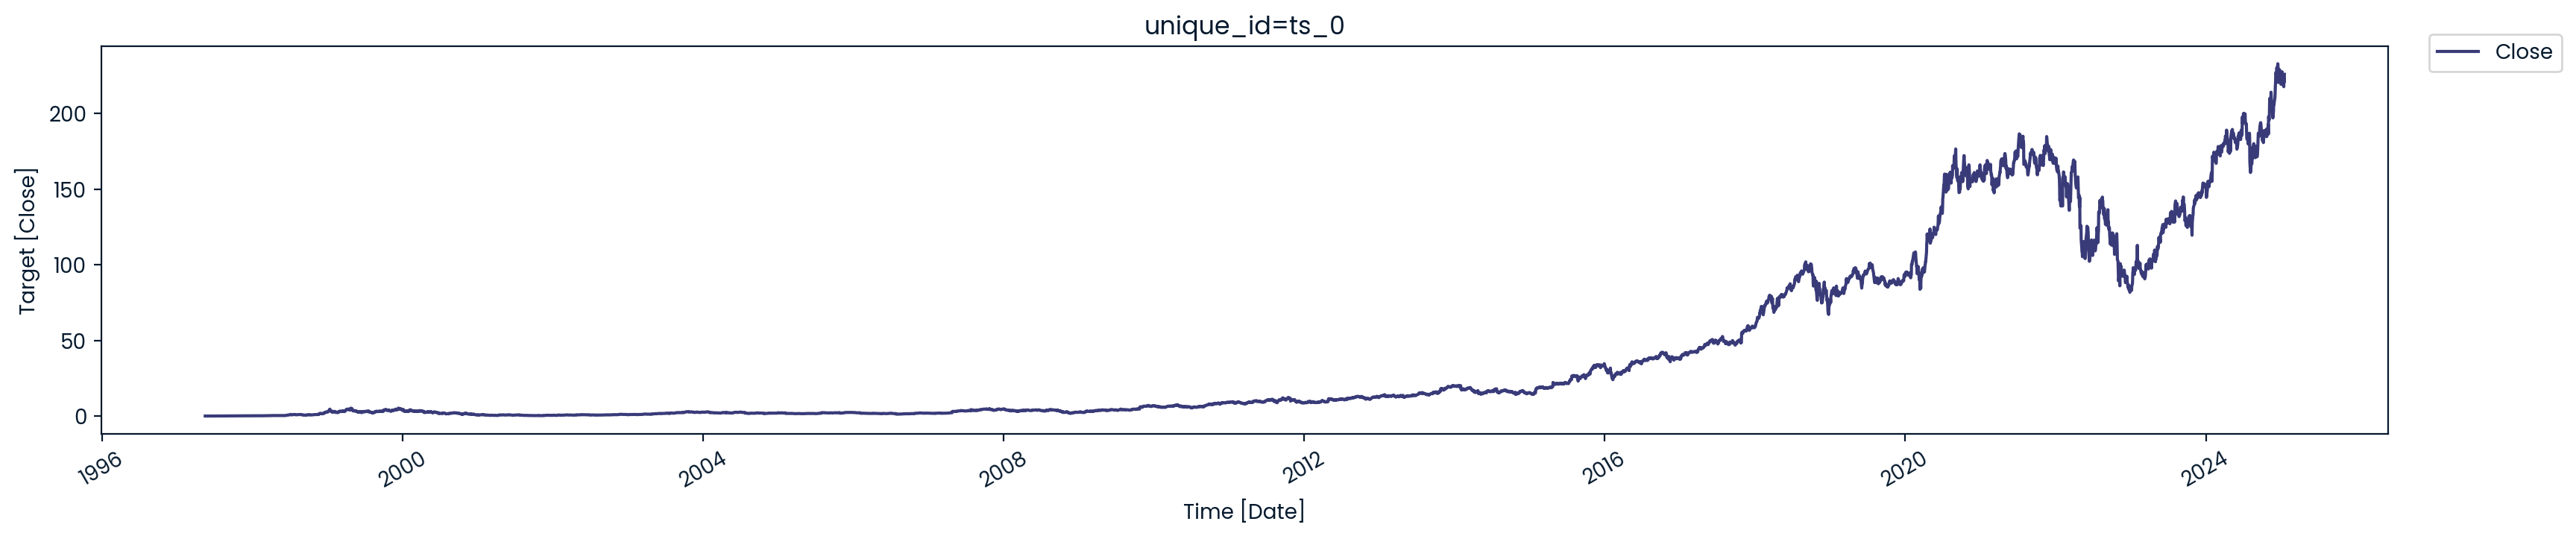

In [6]:
#plot the price stock data
nixtla_client.plot(amazon_stock_data, time_col='Date', target_col='Close')

In [7]:
# Ensure the 'Date' column is in datetime format
amazon_stock_data['Date'] = pd.to_datetime(amazon_stock_data['Date'])

# Set the 'Date' column as the index
amazon_stock_data.set_index('Date', inplace=True)

# Resample the data to ensure it matches the provided frequency 'B' (business days)
amazon_stock_data = amazon_stock_data.resample('B').asfreq()

# Fill missing values if any (optional, depending on the use case)
amazon_stock_data['Close'].fillna(method='ffill', inplace=True)

# Reset the index to have 'Date' as a column again
amazon_stock_data.reset_index(inplace=True)

In [8]:
# Forecast using the nixtla_client
model = nixtla_client.forecast(
    df=amazon_stock_data,
    model="timegpt-1",
    h=24,
    freq="B",
    time_col="Date",
    target_col="Close",
)
model.tail()

,Date,TimeGPT
19,2025-02-14,223.79468
20,2025-02-17,223.46533
21,2025-02-18,223.17096
22,2025-02-19,222.57132
23,2025-02-20,222.60022


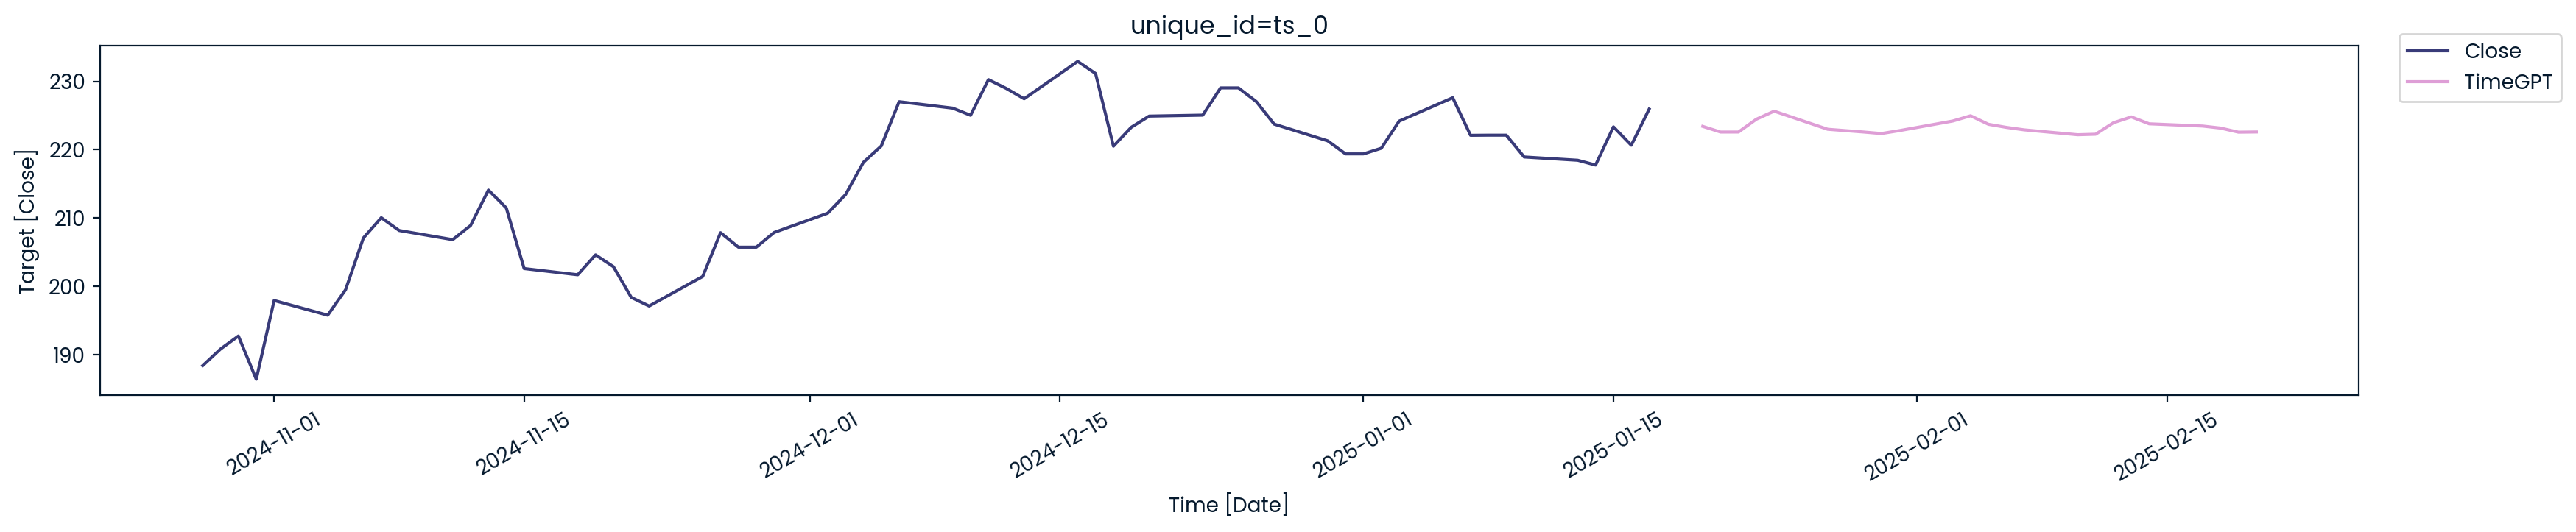

In [9]:
# Plot the actual and forecast datasets to show model's prediction
nixtla_client.plot(
    amazon_stock_data,
    model,
    time_col="Date",
    target_col="Close",
    max_insample_length=60,
)

**This was an introductory project. In the next phase, we will work with more complex datasets and explore additional features of the Nixtla API.**

**Forecasting Australian Electricity Demand using TimeGPT**

**In this project, we will use a more complex dataset of [Australian Electricity Demand](https://zenodo.org/records/4659727
) and use the TimeGPT model to forecast multiple values at once.**

**Loading the dataset**

In [106]:
import pandas as pd

def read_tsf_from_file(file_path):
    data = []
    start_date = pd.to_datetime("2002-01-01 00:00:00")

    # Open and read the file from the directory
    with open(file_path, "r") as file:
        for line in file:
            if line.startswith("T"):
                parts = line.strip().split(":")
                unique_id = parts[0] + "-" + parts[1]
                values = list(map(float, parts[3].split(",")[:-1]))

                # Generate datetime index at half-hour intervals
                periods = len(values)
                date_range = pd.date_range(
                    start=start_date, periods=periods, freq="30min"
                )

                # Append to data list
                for dt, value in zip(date_range, values):
                    data.append([unique_id, dt, value])
    # Convert the list of data into a DataFrame
    return pd.DataFrame(data, columns=["unique_id", "ds", "y"])


# Upload the data and add the file path
file_path = "australian_electricity_demand_dataset.tsf"
demand_df = read_tsf_from_file(file_path)

# Display the dataframe
demand_df.head()

,unique_id,ds,y
0,T1-NSW,2002-01-01 00:00:00,5714.045004
1,T1-NSW,2002-01-01 00:30:00,5360.189078
2,T1-NSW,2002-01-01 01:00:00,5014.835118
3,T1-NSW,2002-01-01 01:30:00,4602.755516
4,T1-NSW,2002-01-01 02:00:00,4285.179828


Our dataset has three columns: 

1. **unique_id:** represents 5 states in Australia.
2. **ds:** data and time.
3. **y:** electricity demand.

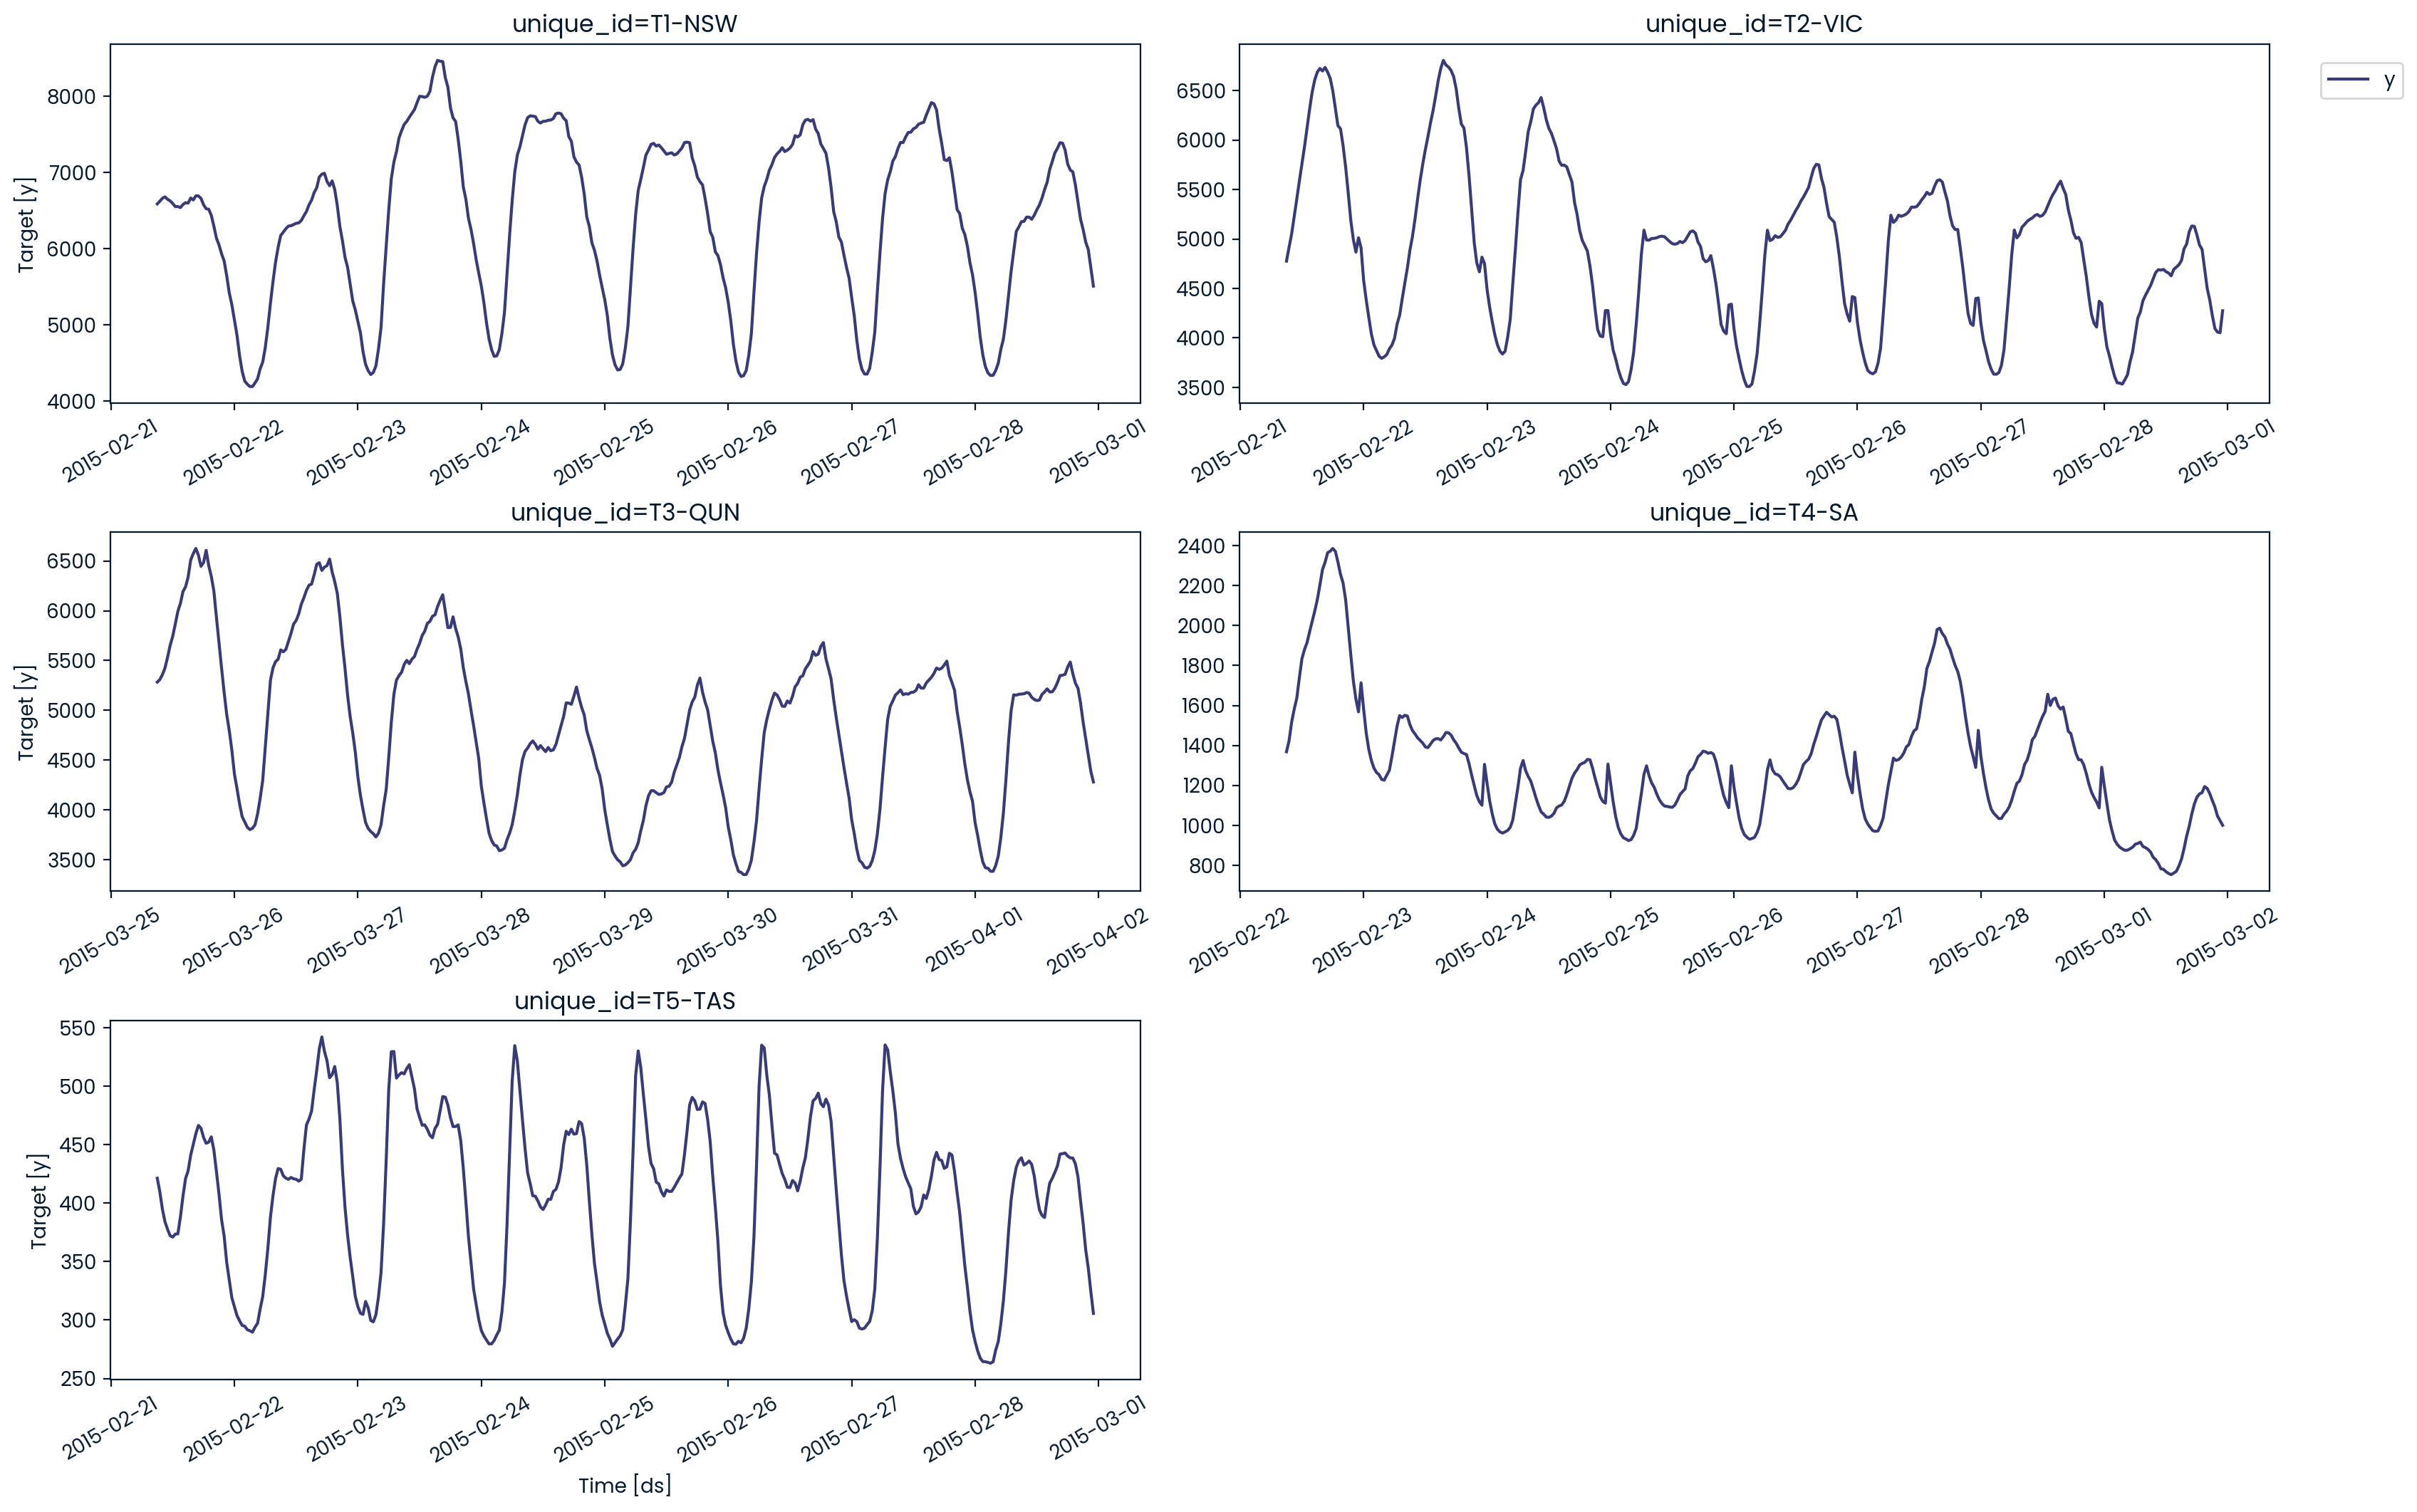

In [107]:
nixtla_client.plot(
    demand_df, 
    max_insample_length=365, 
)

The visualization shows the power consumption of 5 states, and they all have different patterns.

**Anomaly detection**

Before we forecast, we will identify various anomalies in the dataset to understand the problem better. 

**Verify Timestamp Alignment**

In [108]:
print(demand_df['ds'].diff().value_counts())

ds
0 days 00:30:00         1155254
-4807 days +01:00:00          2
-4839 days +01:00:00          1
-4808 days +01:00:00          1
Name: count, dtype: int64


The output reveals that there are 115,5254 records with this frequency. Most timestamps in the dataset have a 0 days 00:30:00 difference, indicating a 30-minute interval rather than the expected hourly (1-hour) interval. Additionally, there are irregular differences (-4807 days +01:00:00, etc.), which might be anomalies or errors in the dataset.

**Steps to Resolve**

**1. Filter Out Irregular Timestamps**

We need to remove timestamps with irregular differences to ensure consistency

In [109]:
# Calculate differences
demand_df['time_diff'] = demand_df['ds'].diff()

# Filter out rows with irregular time differences
demand_df = demand_df[demand_df['time_diff'] == pd.Timedelta('00:30:00')]

# Drop the helper column
demand_df.drop(columns=['time_diff'], inplace=True)

**2. Resample to Hourly Frequency**

Since the dataset is at a 30-minute frequency, we need to resample it to hourly frequency

In [110]:
print(demand_df.dtypes)

unique_id            object
ds           datetime64[ns]
y                   float64
dtype: object


In [111]:
# Resample only the numeric column 'y'
demand_df_resampled = demand_df.set_index('ds')[['y']].resample('H').mean()

# Reset the index after resampling
demand_df_resampled.reset_index(inplace=True)

In [112]:
# Resample 'unique_id' column (take the first value within each hour)
unique_id_resampled = demand_df.set_index('ds')['unique_id'].resample('H').first()

# Combine the resampled numeric data with the resampled 'unique_id' column
demand_df_resampled = pd.concat([demand_df_resampled.set_index('ds'), unique_id_resampled], axis=1)

# Reset the index
demand_df_resampled.reset_index(inplace=True)

In [113]:
print(demand_df_resampled['ds'].diff().value_counts())

ds
0 days 01:00:00    116135
Name: count, dtype: int64


In [114]:
print(demand_df_resampled.isnull().sum())

ds           0
y            0
unique_id    0
dtype: int64


In [115]:
# Generate a range of timestamps from the minimum to the maximum in the 'ds' column
expected_range = pd.date_range(start=demand_df['ds'].min(), end=demand_df['ds'].max(), freq='H')

# Check for missing timestamps
missing_timestamps = expected_range.difference(demand_df['ds'])
if not missing_timestamps.empty:
    print(f"Missing timestamps:\n{missing_timestamps}")
else:
    print("No missing timestamps.")

No missing timestamps.


In [116]:
# Check for duplicate timestamps
duplicate_timestamps = demand_df[demand_df.duplicated(subset='ds', keep=False)]
if not duplicate_timestamps.empty:
    print(f"Duplicate timestamps:\n{duplicate_timestamps}")
else:
    print("No duplicate timestamps.")

Duplicate timestamps:
        unique_id                  ds            y
1          T1-NSW 2002-01-01 00:30:00  5360.189078
2          T1-NSW 2002-01-01 01:00:00  5014.835118
3          T1-NSW 2002-01-01 01:30:00  4602.755516
4          T1-NSW 2002-01-01 02:00:00  4285.179828
5          T1-NSW 2002-01-01 02:30:00  4074.894442
...           ...                 ...          ...
1155254    T5-TAS 2015-02-28 21:00:00   382.657214
1155255    T5-TAS 2015-02-28 21:30:00   360.118254
1155256    T5-TAS 2015-02-28 22:00:00   344.564576
1155257    T5-TAS 2015-02-28 22:30:00   324.242366
1155258    T5-TAS 2015-02-28 23:00:00   305.643636

[1153766 rows x 3 columns]


In [117]:
# Ensure 'ds' is in datetime format before proceeding
if 'ds' not in demand_df.columns:
    demand_df['ds'] = pd.to_datetime(demand_df['ds'])

# Remove duplicates based only on 'ds' column, keeping the first occurrence
demand_df = demand_df.drop_duplicates(subset='ds', keep='first')

# Sort the DataFrame by 'ds' column after removing duplicates
demand_df = demand_df.sort_values(by='ds')

# Set 'ds' as the index
demand_df.set_index('ds', inplace=True)

# Resample to hourly frequency and forward fill missing values
demand_df = demand_df.resample('H').ffill()

# Reset the index to make 'ds' a column again
demand_df.reset_index(inplace=True)

# Check the columns to ensure 'ds' is present
print(demand_df.columns)

# Check for duplicate timestamps again after processing
duplicate_timestamps = demand_df[demand_df.duplicated(subset='ds', keep=False)]
if not duplicate_timestamps.empty:
    print(f"Duplicate timestamps:\n{duplicate_timestamps}")
else:
    print("No duplicate timestamps.")

Index(['ds', 'unique_id', 'y'], dtype='object')
No duplicate timestamps.


In [118]:
# Check for missing values in the 'y' column
missing_values = demand_df['y'].isna().sum()
print(f"Missing values in 'y': {missing_values}")

Missing values in 'y': 1


In [119]:
# Fill the last missing value with the mean of the column 
demand_df['y'] = demand_df['y'].fillna(demand_df['y'].mean())

# Verify there are no missing values left
missing_values_after_fill = demand_df['y'].isna().sum()
print(f"Missing values in 'y' after filling: {missing_values_after_fill}")

Missing values in 'y' after filling: 0


In [121]:
# Verify the frequency of the datetime index
print(f"Time frequency: {demand_df['ds'].diff().mode()[0]}")

# Check if there are any missing timestamps
missing_timestamps = pd.date_range(start=demand_df['ds'].min(), end=demand_df['ds'].max(), freq='H').difference(demand_df['ds'])
print(f"Missing timestamps: {len(missing_timestamps)}")

Time frequency: 0 days 01:00:00
Missing timestamps: 0


In [122]:
# Check for any invalid values (NaN, Inf, etc.) in the 'y' column
invalid_values_in_y = demand_df['y'].isna().sum() + (demand_df['y'] == float('inf')).sum() + (demand_df['y'] == float('-inf')).sum()
print(f"Invalid values in 'y': {invalid_values_in_y}")

Invalid values in 'y': 0


In [123]:
# Check the time difference between consecutive timestamps
time_differences = demand_df['ds'].diff().unique()
print(f"Time differences between consecutive timestamps: {time_differences}")

Time differences between consecutive timestamps: <TimedeltaArray>
[NaT, '0 days 01:00:00']
Length: 2, dtype: timedelta64[ns]


In [124]:
# Remove rows with NaT (Not a Time) values in the 'ds' column
demand_df = demand_df[demand_df['ds'].notna()]

# Check the time differences between consecutive timestamps again
time_differences = demand_df['ds'].diff().unique()
print(f"Time differences between consecutive timestamps after cleaning: {time_differences}")

# Check for missing timestamps
missing_timestamps = pd.date_range(start=demand_df['ds'].min(), end=demand_df['ds'].max(), freq='H')
missing_timestamps_in_data = missing_timestamps.difference(demand_df['ds'])
print(f"Missing timestamps: {missing_timestamps_in_data}")

# Ensure there are no duplicate timestamps
duplicate_timestamps = demand_df[demand_df.duplicated(subset='ds', keep=False)]
if not duplicate_timestamps.empty:
    print(f"Duplicate timestamps:\n{duplicate_timestamps}")
else:
    print("No duplicate timestamps.")

Time differences between consecutive timestamps after cleaning: <TimedeltaArray>
[NaT, '0 days 01:00:00']
Length: 2, dtype: timedelta64[ns]
Missing timestamps: DatetimeIndex([], dtype='datetime64[ns]', freq='h')
No duplicate timestamps.


In [126]:
# Ensure 'ds' is in datetime format
demand_df['ds'] = pd.to_datetime(demand_df['ds'], errors='coerce')

# Remove any rows with invalid datetime entries
demand_df = demand_df.dropna(subset=['ds'])

# Remove duplicates based on 'ds' and sort the DataFrame
demand_df = demand_df.drop_duplicates(subset='ds', keep='first')
demand_df = demand_df.sort_values(by='ds')

# Check the first few timestamps to inspect for any anomalies
print(f"First few timestamps:\n{demand_df['ds'].head()}")

# Create a range of timestamps from the min to max of the 'ds' column with hourly frequency
all_timestamps = pd.date_range(start=demand_df['ds'].min(), end=demand_df['ds'].max(), freq='H')

# Find missing timestamps (if any)
missing_timestamps = all_timestamps.difference(demand_df['ds'])
print(f"Missing timestamps: {missing_timestamps}")

# Resample the data to ensure hourly frequency, filling any missing values with forward fill
demand_df = demand_df.set_index('ds').reindex(all_timestamps).ffill()

# Reset index to make 'ds' a column again
demand_df.reset_index(inplace=True)
demand_df.rename(columns={'index': 'ds'}, inplace=True)

# Check for duplicate timestamps after resampling
duplicate_timestamps = demand_df[demand_df.duplicated(subset='ds', keep=False)]
if not duplicate_timestamps.empty:
    print(f"Duplicate timestamps:\n{duplicate_timestamps}")
else:
    print("No duplicate timestamps.")

# Check the time differences between consecutive timestamps
time_differences = demand_df['ds'].diff().unique()
print(f"Time differences between consecutive timestamps: {time_differences}")

First few timestamps:
0   2002-01-01 00:00:00
1   2002-01-01 01:00:00
2   2002-01-01 02:00:00
3   2002-01-01 03:00:00
4   2002-01-01 04:00:00
Name: ds, dtype: datetime64[ns]
Missing timestamps: DatetimeIndex([], dtype='datetime64[ns]', freq='h')
No duplicate timestamps.
Time differences between consecutive timestamps: <TimedeltaArray>
[NaT, '0 days 01:00:00']
Length: 2, dtype: timedelta64[ns]


In [127]:
# Ensure 'ds' is in datetime format
demand_df['ds'] = pd.to_datetime(demand_df['ds'], errors='coerce')

# Remove any rows with invalid datetime entries
demand_df = demand_df.dropna(subset=['ds'])

# Remove duplicates based on 'ds' and sort the DataFrame
demand_df = demand_df.drop_duplicates(subset='ds', keep='first')
demand_df = demand_df.sort_values(by='ds')

# Create a range of timestamps from the min to max of the 'ds' column with hourly frequency
all_timestamps = pd.date_range(start=demand_df['ds'].min(), end=demand_df['ds'].max(), freq='H')

# Find missing timestamps (if any)
missing_timestamps = all_timestamps.difference(demand_df['ds'])
print(f"Missing timestamps: {missing_timestamps}")

# Resample the data to ensure hourly frequency, filling any missing values with forward fill
demand_df = demand_df.set_index('ds').reindex(all_timestamps).ffill()

# Reset index to make 'ds' a column again
demand_df.reset_index(inplace=True)
demand_df.rename(columns={'index': 'ds'}, inplace=True)

# Handle the first row time difference as NaT might occur due to no previous timestamp
time_differences = demand_df['ds'].diff().fillna(pd.Timedelta(0)).unique()
print(f"Time differences between consecutive timestamps: {time_differences}")

# Check for duplicate timestamps after resampling
duplicate_timestamps = demand_df[demand_df.duplicated(subset='ds', keep=False)]
if not duplicate_timestamps.empty:
    print(f"Duplicate timestamps:\n{duplicate_timestamps}")
else:
    print("No duplicate timestamps.")

Missing timestamps: DatetimeIndex([], dtype='datetime64[ns]', freq='h')
Time differences between consecutive timestamps: <TimedeltaArray>
['0 days 00:00:00', '0 days 01:00:00']
Length: 2, dtype: timedelta64[ns]
No duplicate timestamps.


It seems like the missing timestamps issue is resolved, and the time differences are now showing as expected (0 days 00:00:00 for the first row and 0 days 01:00:00 for subsequent rows).

In [129]:
# Convert 'ds' to datetime format (if not already in that format)
demand_df['ds'] = pd.to_datetime(demand_df['ds'], errors='coerce')

# Drop any rows where 'ds' could not be converted to datetime
demand_df = demand_df.dropna(subset=['ds'])

# Remove duplicates based on 'ds', keeping the first occurrence
demand_df = demand_df.drop_duplicates(subset='ds', keep='first')

# Sort the DataFrame by 'ds' to ensure chronological order
demand_df = demand_df.sort_values(by='ds')

# Reindex the DataFrame to ensure it has a consistent hourly frequency
demand_df = demand_df.set_index('ds').resample('H').ffill()

# Reset index to make 'ds' a column again
demand_df.reset_index(inplace=True)

# Check the first few rows to ensure the 'ds' column is consistent
print(demand_df.head())

# Check for missing timestamps
missing_timestamps = pd.date_range(start=demand_df['ds'].min(), end=demand_df['ds'].max(), freq='H')
missing_timestamps = missing_timestamps.difference(demand_df['ds'])

# Print missing timestamps (if any)
if len(missing_timestamps) > 0:
    print(f"Missing timestamps: {missing_timestamps}")
else:
    print("No missing timestamps.")

# Verify there are no duplicates
duplicate_timestamps = demand_df[demand_df.duplicated(subset='ds', keep=False)]
if not duplicate_timestamps.empty:
    print(f"Duplicate timestamps:\n{duplicate_timestamps}")
else:
    print("No duplicate timestamps.")

                   ds unique_id            y
0 2002-01-01 00:00:00       NaN  6729.301269
1 2002-01-01 01:00:00    T1-NSW  5014.835118
2 2002-01-01 02:00:00    T1-NSW  4285.179828
3 2002-01-01 03:00:00    T1-NSW  3942.936134
4 2002-01-01 04:00:00    T1-NSW  3877.679938
No missing timestamps.
No duplicate timestamps.


In [130]:
# We can drop rows with NaN 'unique_id'
demand_df = demand_df.dropna(subset=['unique_id'])

In [131]:
# Detect anomalies using the cleaned data
anomalies_df = nixtla_client.detect_anomalies(
    demand_df, 
    time_col='ds', 
    target_col='y', 
    freq='H', 
)

# Display anomalies
print(anomalies_df[anomalies_df["anomaly"] == 1].head())

   unique_id                  ds  ...  TimeGPT-lo-99  anomaly
8     T1-NSW 2002-01-07 08:00:00  ...       4704.369     True
9     T1-NSW 2002-01-07 09:00:00  ...       5025.020     True
14    T1-NSW 2002-01-07 14:00:00  ...       5623.774     True
15    T1-NSW 2002-01-07 15:00:00  ...       5707.266     True
16    T1-NSW 2002-01-07 16:00:00  ...       5694.420     True

[5 rows x 7 columns]


We have displayed all the instances where anomalies were detected.

In [132]:
anomalies_df.anomaly.value_counts()

anomaly
False    112767
True       3105
Name: count, dtype: int64

The total number of anomalies in all 5 time series datasets is 3105

Now, we will plot the anomalies on the actual dataset to see where and how often they occur from day to day. To simplify the visualization, we will only display 5,000 samples from New South Wales.

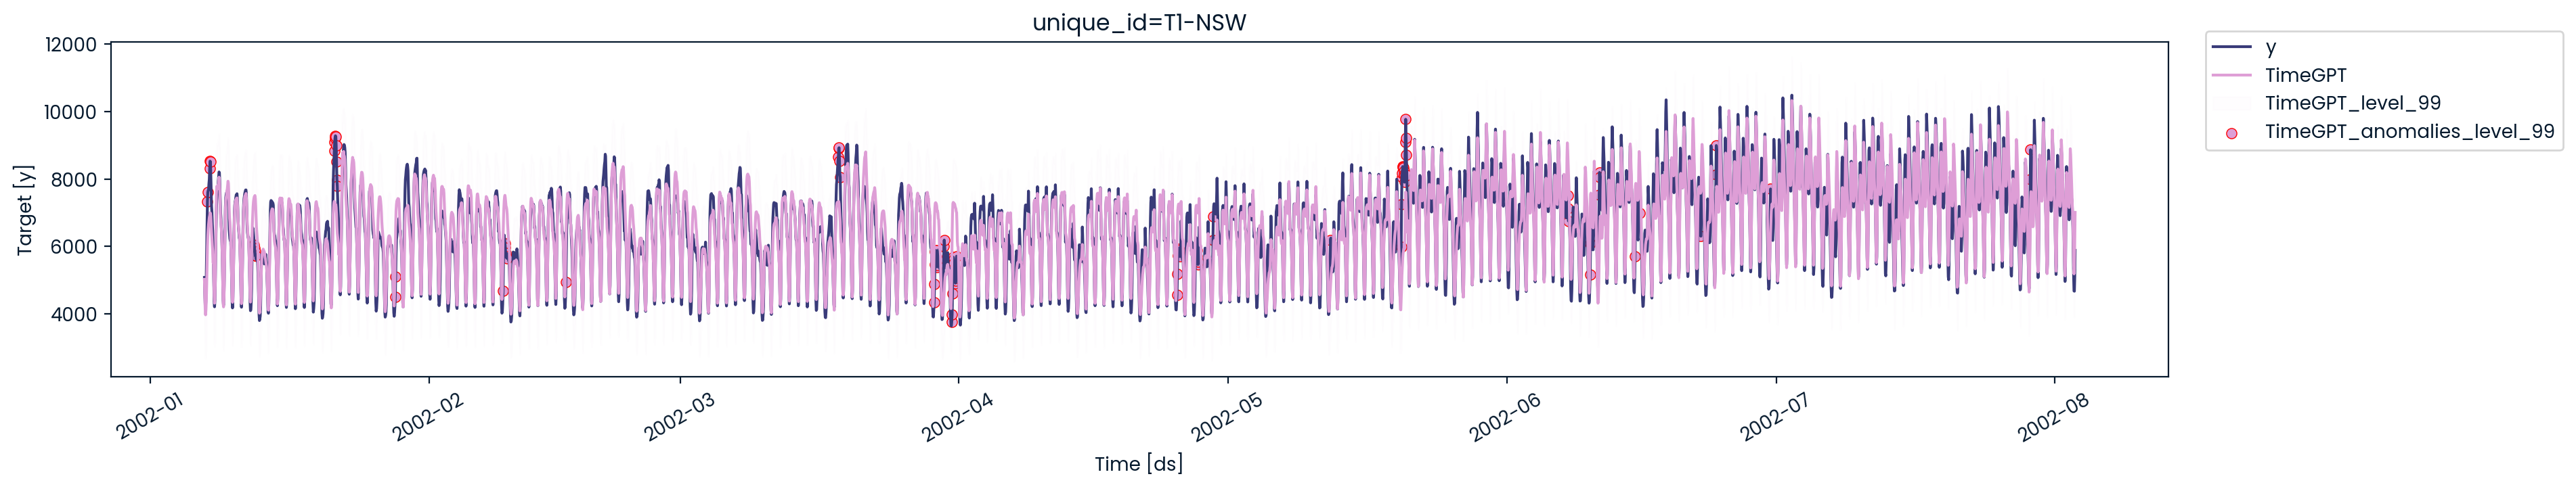

In [133]:
# Plot anomalies
nixtla_client.plot(
    demand_df[demand_df["unique_id"]=="T1-NSW"][0:5000], 
    anomalies_df[anomalies_df["unique_id"]=="T1-NSW"][0:5000],
    time_col='ds', 
    target_col='y',
    
)

The anomalies on a daily basis are not common, but there have been days when multiple anomalies occur in a single day.

**Single series forecasting with TimeGPT**

We will now forecast the New South Wales electricity demand. For that, we will filter out only the values for "T1-NSW".

In [134]:
T1_df = demand_df[demand_df["unique_id"]=="T1-NSW"]
T1_df.head()

,ds,unique_id,y
1,2002-01-01 01:00:00,T1-NSW,5014.835118
2,2002-01-01 02:00:00,T1-NSW,4285.179828
3,2002-01-01 03:00:00,T1-NSW,3942.936134
4,2002-01-01 04:00:00,T1-NSW,3877.679938
5,2002-01-01 05:00:00,T1-NSW,3897.023942


Plot the latest 365 values to understand the electrical consumption pattern. 

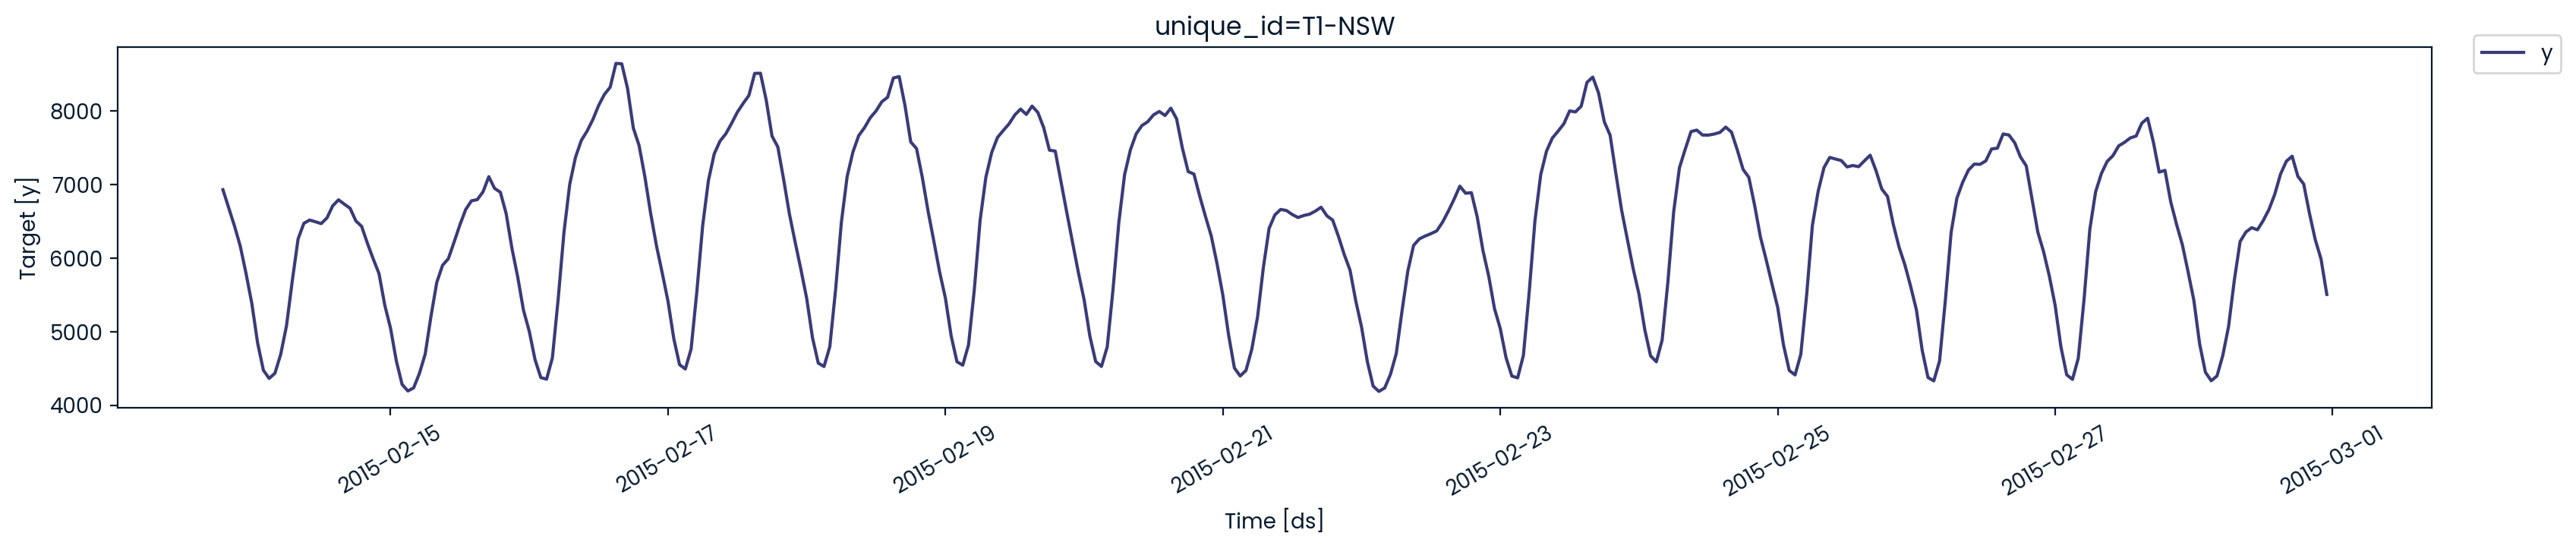

In [135]:
nixtla_client.plot(
    T1_df, 
    max_insample_length=365, 
)

We will now evaluate our model's performance. To do so, we need to split our dataset into training and testing sets. 

The testing set consists of 144 values, which equates to 3 days, and the training set consists of 1200 values, which equates to 25 days.

In [137]:
test_df = T1_df.tail(144) # 3 days = (144 * 0.5h *  1 day/24h) 
train_df = T1_df.iloc[-1344:-144] # 25 days = (1200 *0.5h * 1 day/24h)

For forecasting, we will select a better model and set various arguments to improve model performance, specifically:

1. Forecast the next 144 values (3 days).
2. Forecast 90% confidence interval. 
3. Fine-tune the model with 60 steps, which is a lot, but it will give a better result. 
4. Set loss function to MAE. 
5. Use the TimeGPT-1-long-horizon model instead of a simple one. 
6. Set time and target columns.

In [139]:
predict_df = nixtla_client.forecast(
    df=train_df,
    h=144,
    level=[90],  # Generate a 90% confidence interval
    finetune_steps=60,  # Specify the number of steps for fine-tuning
    finetune_loss="mae",  # Use the MAE as the loss function for fine-tuning
    model="timegpt-1-long-horizon",  # Use the model for long-horizon forecasting
    time_col="ds",
    target_col="y",
)

Plot the actual, forecast, and 90 percent confidence interval to assess the model's performance.

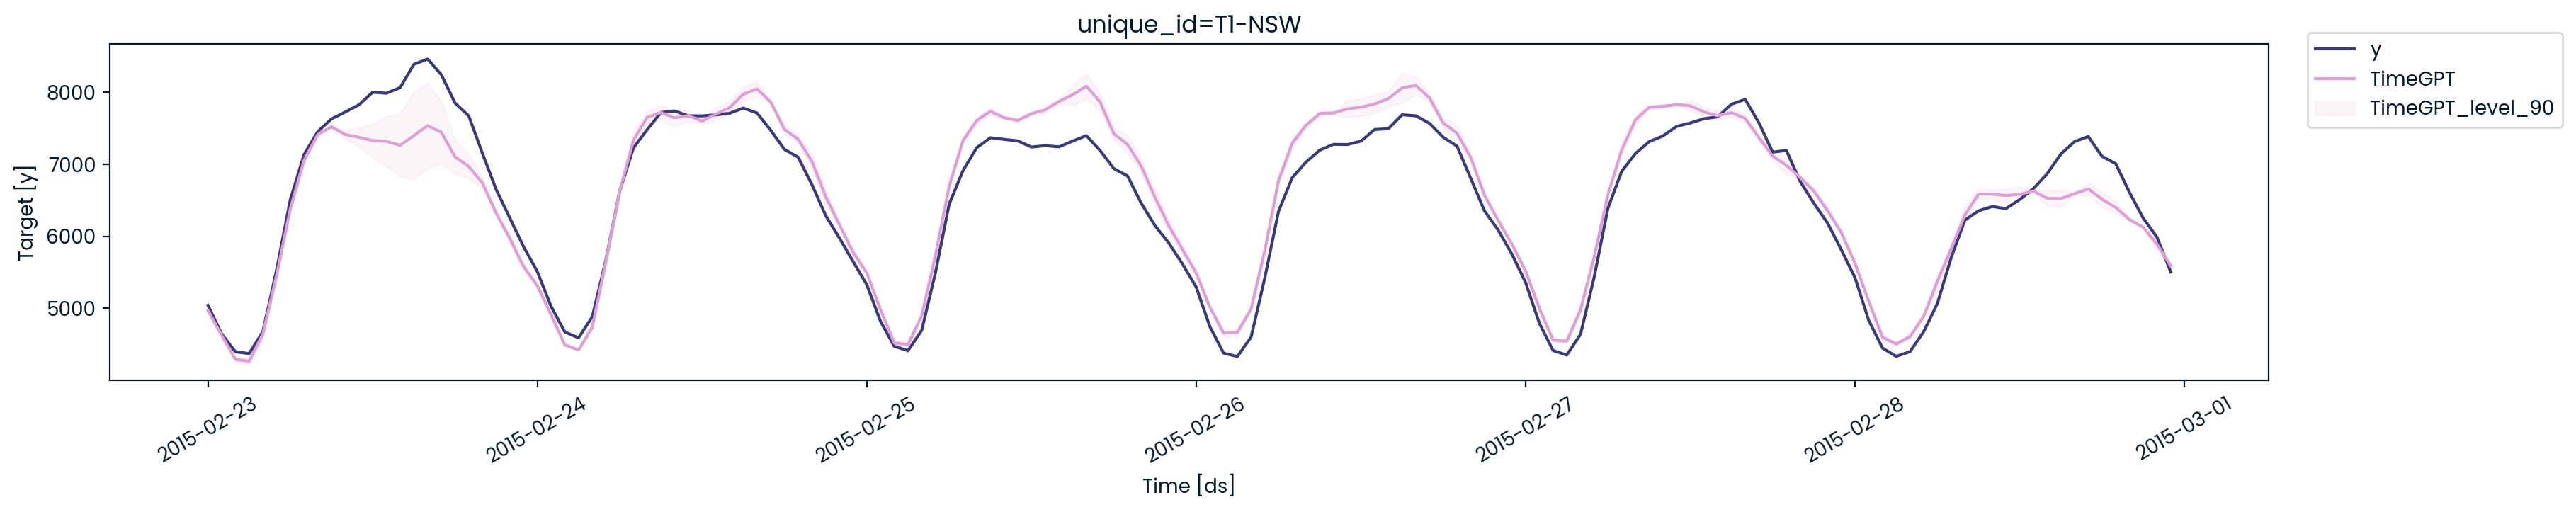

In [140]:
nixtla_client.plot(
    test_df, predict_df, models=["TimeGPT"], level=[90], time_col="ds", target_col="y"
)

Within a few seconds, we got a fairly accurate result. That is the power of pre-trained models.

We will now evaluate the model performance using the UtilsForecast library, which is part of the Nixtla open-source project. To do this, we will merge the test and forecast datasets and then provide them to the evaluate function. The function takes the dataset, metrics, models, target columns, and a unique ID to calculate the model metrics and display them as a pandas data frame.

In [141]:
from utilsforecast.losses import mae, rmse, smape
from utilsforecast.evaluation import evaluate

predict_df["ds"] = pd.to_datetime(predict_df["ds"])
test_df = pd.merge(test_df, predict_df, "left", ["ds", "unique_id"])
evaluation = evaluate(
    test_df,
    metrics=[mae, rmse, smape],
    models=["TimeGPT"],
    target_col="y",
    id_col="unique_id",
)

average_metrics = evaluation.groupby("metric")["TimeGPT"].mean()
average_metrics

metric
mae      290.674026
rmse     356.698462
smape      0.021760
Name: TimeGPT, dtype: float64

We got fairly good results. 

**Multiple series forecasting with TimeGPT**

The Nixtla API also allows you to forecast multiple series at once. We will use the entire dataset instead of filtering based on a unique ID. 

To split the dataset into the train and test sets, we use the groupby function to split the 144 values for each unique ID. Otherwise, we would have only 144 values for some randomly chosen unique ID.

In [143]:
#values for some randomly chosen unique ID.
test_df = demand_df.groupby("unique_id").tail(144)  # 3 days
train_df = (
    demand_df.groupby("unique_id")
    .apply(lambda group: group.iloc[-1344:-144])
    .reset_index(drop=True)
)  # 25 days

The forecast function is the same as in the previous part, except this time, we are also including the ID columns.

Check the number of observations per series

In [145]:
series_lengths = demand_df.groupby('unique_id').size()
print(series_lengths)

unique_id
T1-NSW    115367
T3-QUN       768
dtype: int64


Since the **TimeGPT** model requires at least 1008 observations per series, the **T3-QUN** series is too short to be used in forecasting.

**Cross-validation**

The Nixtla client also allows us to perform cross-validation to evaluate model performance on various windows of the dataset.

We will use the .cross_validation function and provide it with the filtered dataset that contains only New South Wales values. The cross-validation will have 5 windows, each with a length of 7 hours.

In [146]:
timegpt_cv_df = nixtla_client.cross_validation(
    T1_df, 
    h=7, 
    n_windows=5, 
    time_col='ds', 
    target_col='y', 
    freq='H',
)
timegpt_cv_df.head()

,unique_id,ds,cutoff,y,TimeGPT
0,T1-NSW,2015-02-27 13:00:00,2015-02-27 12:00:00,7631.588580,7541.1860
1,T1-NSW,2015-02-27 14:00:00,2015-02-27 12:00:00,7656.584854,7605.4500
2,T1-NSW,2015-02-27 15:00:00,2015-02-27 12:00:00,7832.337408,7742.2260
3,T1-NSW,2015-02-27 16:00:00,2015-02-27 12:00:00,7899.214362,7728.5500
4,T1-NSW,2015-02-27 17:00:00,2015-02-27 12:00:00,7572.659746,7614.4326


As we can see, we got forecast values based on the five 7-hour windows.

We will use a cutoff date and time to create 5 windows, each showing predicted and actual values.

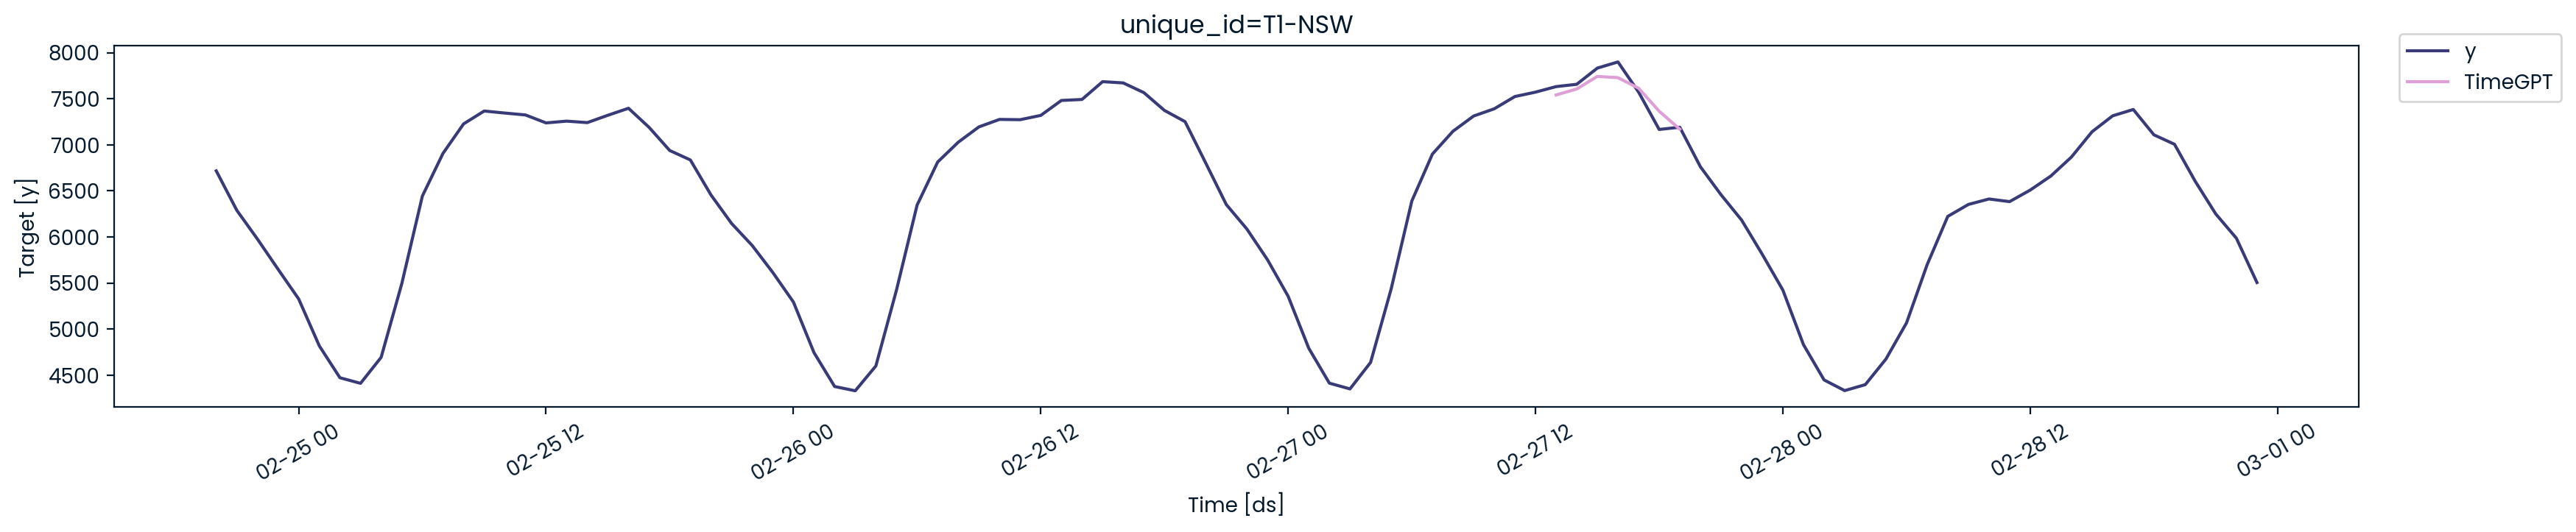

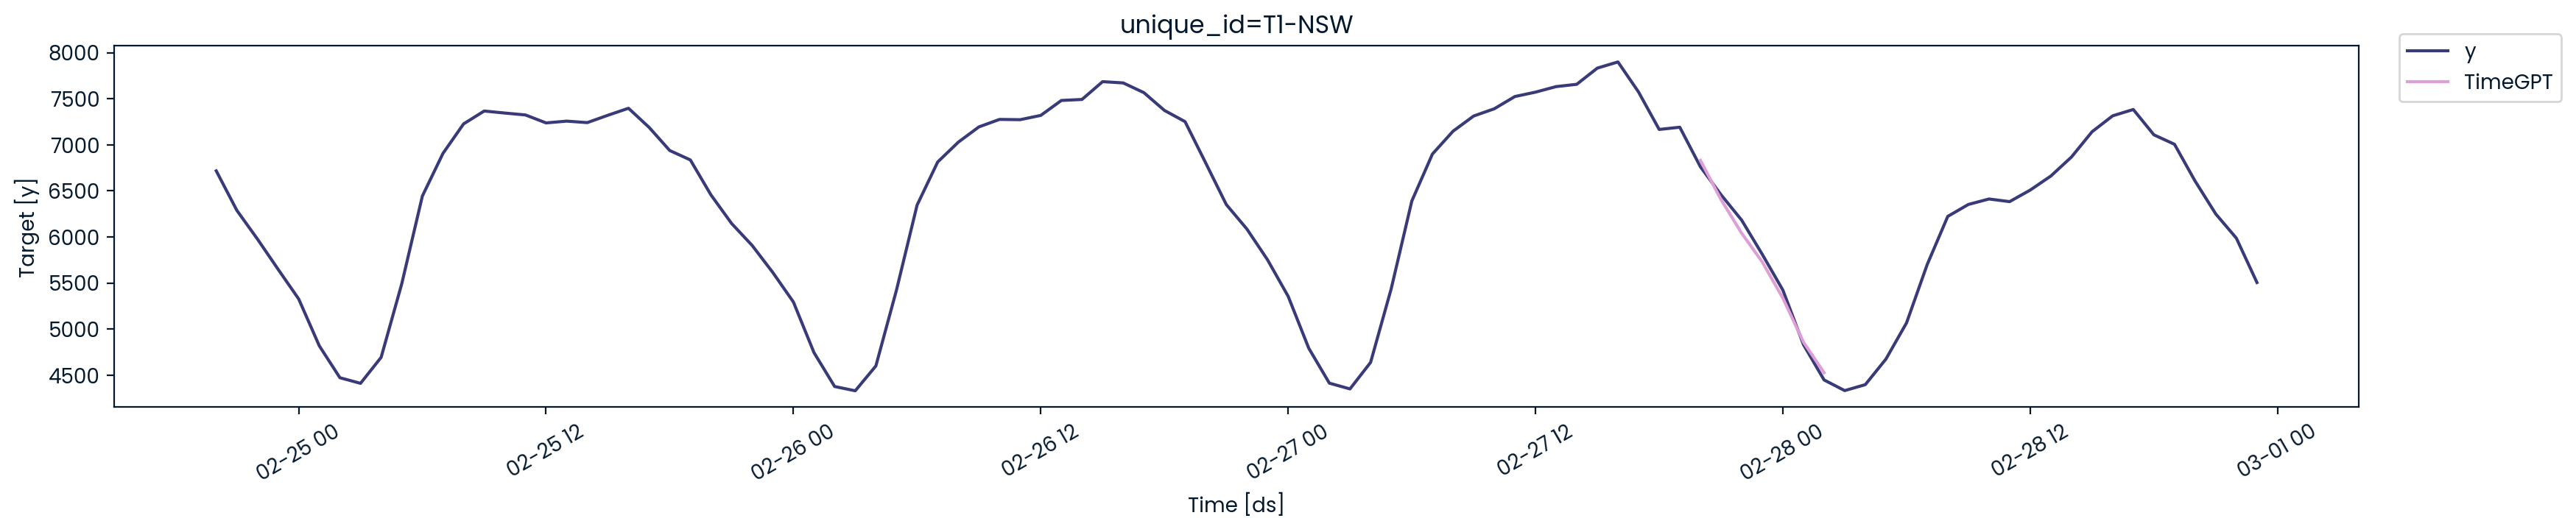

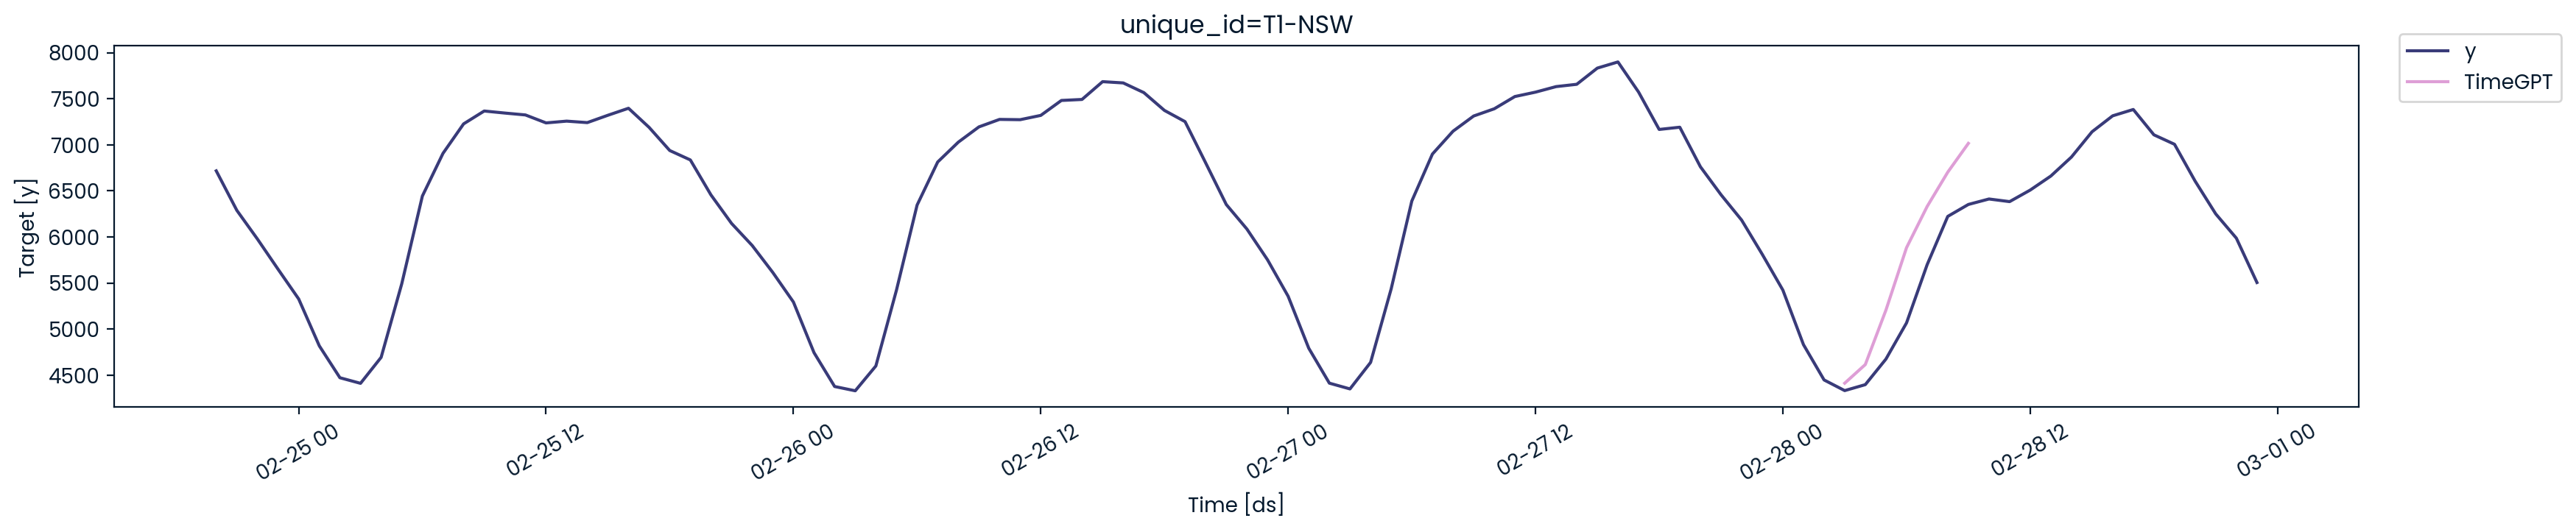

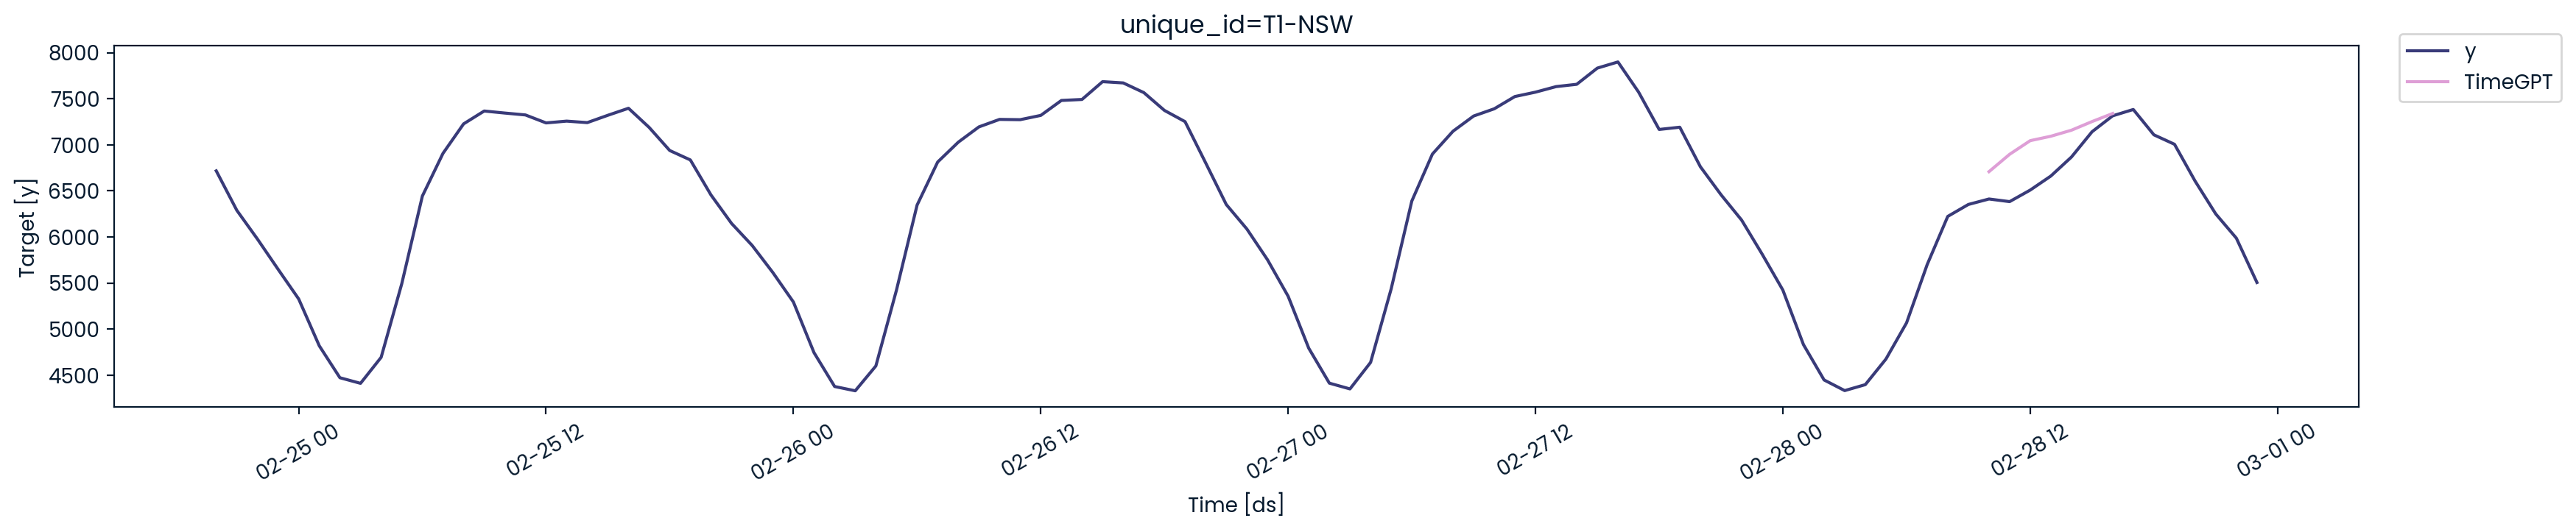

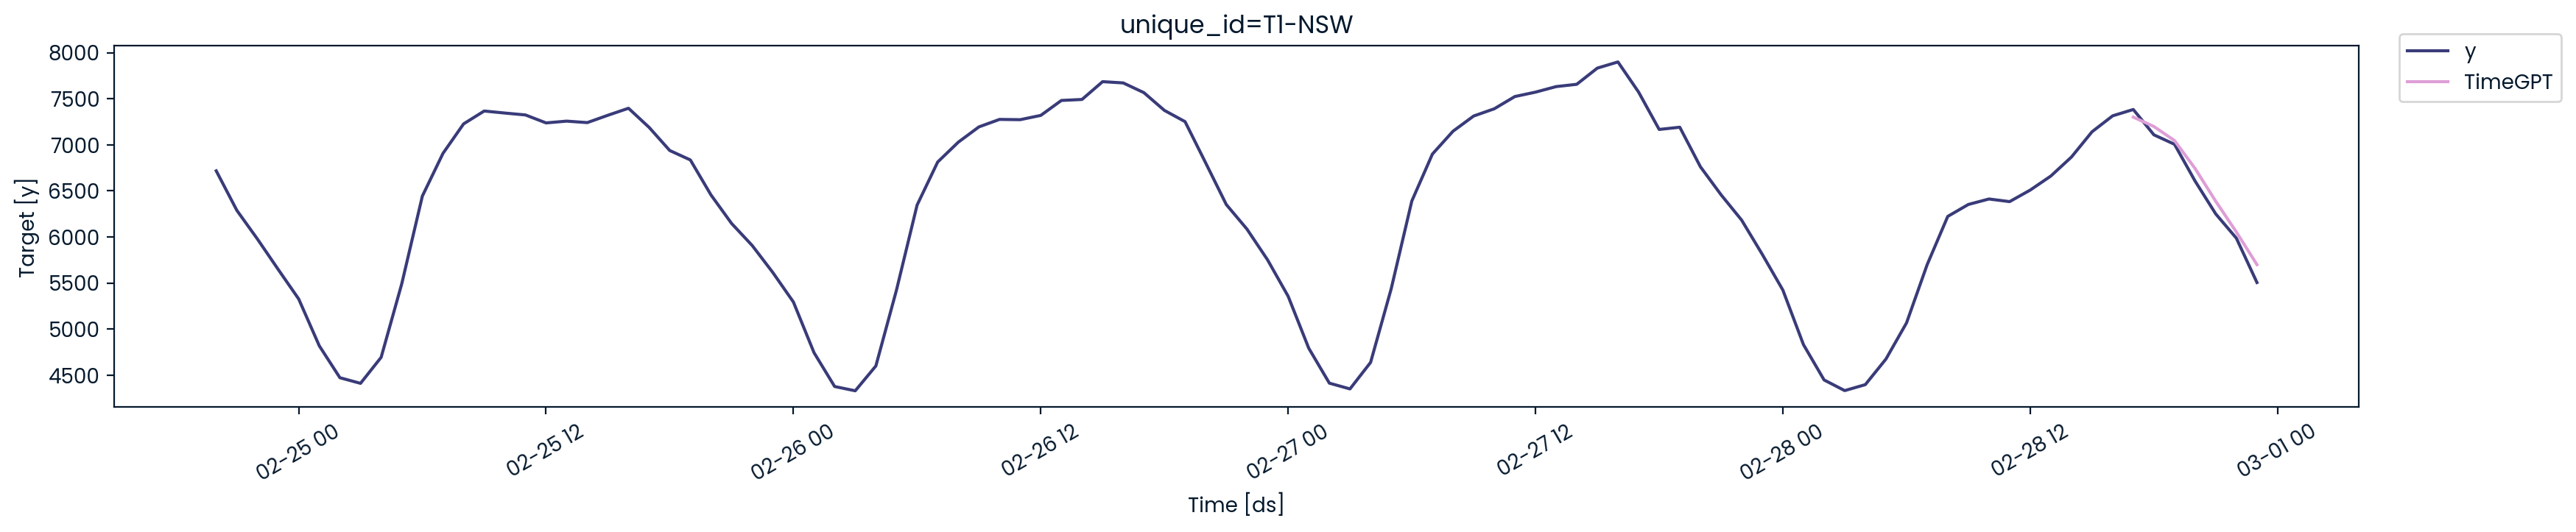

In [147]:
cutoffs = timegpt_cv_df['cutoff'].unique()
for cutoff in cutoffs:
    fig = nixtla_client.plot(
        T1_df.tail(100), 
        timegpt_cv_df.query('cutoff == @cutoff').drop(columns=['cutoff', 'y']),
        time_col='ds', 
        target_col='y'
    )
    display(fig)

Apart from the 3rd and 4th splits, the model has performed quite well.

**Comparing the LGBM with TimeGPT**

Let's now compare the performance of the TimeGPT and Light Gradient-Boosting Machine (LGBM) models to clearly determine which one excels on the same dataset. We have already performed cross-validation on the New South Wales dataframe; the next step is to use the evaluate function to generate the model evaluation report.

In [148]:
evaluation = evaluate(
    timegpt_cv_df,
    metrics=[mae, rmse, smape],
    models=["TimeGPT"],
    target_col="y",
    id_col = "cutoff"
)
evaluation

,cutoff,metric,TimeGPT
0,2015-02-27 12:00:00,mae,94.761273
1,2015-02-27 19:00:00,mae,77.075178
2,2015-02-28 02:00:00,mae,488.610485
3,2015-02-28 09:00:00,mae,315.000392
4,2015-02-28 16:00:00,mae,106.902686
5,2015-02-27 12:00:00,rmse,112.994842
6,2015-02-27 19:00:00,rmse,83.736102
7,2015-02-28 02:00:00,rmse,543.957083
8,2015-02-28 09:00:00,rmse,363.156915
9,2015-02-28 16:00:00,rmse,117.259946


We need to calculate the mean of MAE, RMSE, and SMAPE for all 5 windows in order to obtain the overall result of the model.

In [149]:
average_metrics = evaluation.groupby('metric')["TimeGPT"].mean()
average_metrics

metric
mae      216.470003
rmse     244.220978
smape      0.017531
Name: TimeGPT, dtype: float64

The results are quite good, even on a small set of values. 

To evaluate the LGBM model, we need to follow these steps:

**1. Filter the data:** Ensure the data has similar values to those used in the TimeGPT cross-validation.

**2. Convert date-time:** Transform date-time information into numerical values.

**3. Feature engineering:** Create additional features using lag and rolling window techniques.

**4. Handle missing values:** Drop any missing values that may arise from creating lags and rolling windows.

**5. Prepare data for modeling:** Define the feature matrix X and target vector y, then split them using TimeSeriesSplit.

**6. Train and evaluate:** Train the model, evaluate it, and record the metrics for each data split.

**7. Aggregate results:** Calculate the mean of each model metric and display the results in a pandas DataFrame.

In [150]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to calculate SMAPE
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Assuming 'ds' is the date/time column and 'y' is the target variable
T1_df['ds'] = pd.to_datetime(T1_df['ds'])

# Filter the DataFrame to include only the specified datetime range
start_date = '2015-02-27T13:00:00'
end_date = '2015-02-28T23:00:00'
T1_df = T1_df[(T1_df['ds'] >= start_date) & (T1_df['ds'] <= end_date)]

# Convert 'ds' to a numerical value (e.g., timestamp)
T1_df['ds_num'] = T1_df['ds'].apply(lambda x: x.timestamp())

# Create lag and window features
for lag in range(1, 4):
    T1_df[f'lag_{lag}'] = T1_df['y'].shift(lag)

T1_df['rolling_mean'] = T1_df['y'].rolling(window=3).mean()
T1_df['rolling_std'] = T1_df['y'].rolling(window=3).std()

# Drop NaN values resulting from lag and rolling operations
T1_df.dropna(inplace=True)

# Select features for the model
X = T1_df[['ds_num', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean', 'rolling_std']]
y = T1_df['y']

# Time series split
tscv = TimeSeriesSplit(n_splits=5)
mae_scores = []
rmse_scores = []
smape_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize and train the LGBM model
    model = lgb.LGBMRegressor(force_row_wise=True, verbosity=-1)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    smape_value = smape(y_test, y_pred)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    smape_scores.append(smape_value)

# Convert the metrics into a DataFrame
mae_avg = np.mean(mae_scores)
rmse_avg = np.mean(rmse_scores)
smape_avg = np.mean(smape_scores)

metrics_df = pd.DataFrame({
    'metric': ['MAE', 'RMSE', 'SMAPE'],
    'LGBM': [mae_avg, rmse_avg, smape_avg]
})

# Display the DataFrame
metrics_df

,metric,LGBM
0,MAE,1037.413476
1,RMSE,1113.207763
2,SMAPE,0.172473


TimeGPT is almost 5 times better than LGBM. 

**Conclusion**

The TimeGPT and Nixtla ecosystem is a game-changer for startups, offering a cost-effective way to access powerful time series models without needing to hire a full team of machine learning or MLOps engineers for model training and deployment. While engineers are still important, this approach can significantly reduce the number of specialized roles required, saving on costs.

Similar to how GPT-3 revolutionized natural language processing, TimeGPT is paving the way for state-of-the-art time series models. As these models continue to improve, many companies are likely to adopt the Nixtla API for easier integration and better performance.

In this project, we dove into TimeGPT, the first foundational model for time series, and explored how to use the Python API for various tasks like forecasting, time series visualization, model evaluation, cross-validation, and anomaly detection.